In [1]:
import pandas as pd
from XRF_calc_tools import *

# get version(s)
#print("pandas version",pd.__version__)

In [2]:
element_list = ['Al2O3', 'CaO', 'Fe2O3', 'MgO', 'MnO', 'P2O5', 
                'SiO2', 'TiO2', 'As', 'Bi', 'Cl', 'Cr', 'Cu', 
                'Hg', 'Mo', 'Nb', 'Ni', 'Pb', 'Rb', 'S', 'Sn', 
                'Sr', 'Ta', 'Th', 'U', 'V', 'W', 'Y', 'Zn', 'Zr']
num_ranges = ['all', '0-750', '250-1000']
filters = ['O1', 'O2']

#### 1. Read in data and references

In [3]:
# get compositions
metadata_path = "Z:\\data_pXRF\\MHC_Olympus_metadata.csv"
metadata = pd.read_csv(metadata_path)
metadata = metadata[
    metadata['Olympus-Predicted'] == 'yes'
]
pred_samples = list(metadata['pkey'])
o1_comps = metadata[metadata['Filter']=='O1'].reset_index(drop=True)
o2_comps = metadata[metadata['Filter']=='O2'].reset_index(drop=True)

for comps in [o1_comps, o2_comps]:
    comps.columns = comps.columns.map(lambda x: x.split()[0])

# get spectra
spectra_path = "Z:\\data_pXRF\\MHC_Olympus_spectra.csv"
spectra = pd.read_csv(spectra_path)
### select samples with olympus predictions
pred_samples.insert(0, 'wave')
pred_spectra = spectra[pred_samples]

o1_spectra = pred_spectra.filter(regex=('(_1$)|(wave)'), axis=1)
o2_spectra = pred_spectra.filter(regex=('(_2$)|(wave)'), axis=1)

#### 2. Calculate instrument sensitivities

Sensitivity calculations for filter 1


  0%|          | 0/190 [00:00<?, ?it/s]

['1984AA', 'C11MA159'] had more than 2 duplicates and were excluded
Median sensitivity: 49.8
Mean sensitivity: 74.6


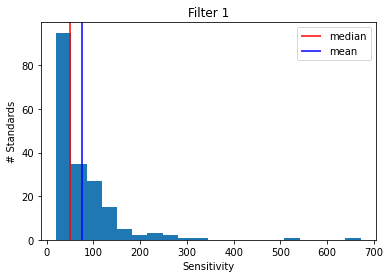

In [ ]:
o1_sens = calculate_sensitivity(filter=1)
o2_sens = calculate_sensitivity(filter=2)

#### 3. Run models, get LBDQ, test models

In [ ]:
# define variables for the PLS models
max_components = 15
n_folds = 10

# prep lists for model summaries
elems = []
ranges = []
rmsecs = []
rmsecvs = []
components = []
test_r2s = []
train_r2s = []
rmseps = []
n_trains = []
n_tests = []
lobs = []
lods = []
loqs = []
fs = []

for f in filters:
    # select relevant metadata and sensitivity
    meta = o1_comps if f == 'O1' else o2_comps
    sensitivity = o1_sens if f == 'O1' else o2_sens
    
    #for regression in regressions: (ADD OTHER REGRESSIONS HERE IF DO IT)
    for num_range in num_ranges:
        print("\rRunning for", f, num_range, "      ")
        
        for element in tqdm(element_list, leave=False):           
            # train model
            rmsecv, component, train_r2, rmsec, n_train = train_PLS_model(
                            element, 
                            f,
                            meta, 
                            spectra,
                            max_components,
                            n_folds,
                            num_range)

            # get LBDQ
            lob, lod, loq = calculate_lbdq(element, 
                                           num_range, 
                                           sensitivity)

            # test models
            if num_range == 'all':
                rmseps.append('NaN')
                n_tests.append('NaN')
                test_r2s.append('NaN')
            else:
                n_test, test_r2, rmsep = test_model(element, 
                                               f,
                                               loq, 
                                               num_range, 
                                               meta,
                                               spectra)
                n_tests.append(n_test)
                test_r2s.append(test_r2)
                rmseps.append(rmsep)
                
            # fill data
            elems.append(element)
            fs.append(f)
            ranges.append(num_range)
            n_trains.append(n_train)
            rmsecs.append(rmsec)
            rmsecvs.append(rmsecv)
            train_r2s.append(train_r2)
            components.append(component)
            lobs.append(lob)
            lods.append(lod)
            loqs.append(loq)
        
        print("\tsuccess")

#### 5. Accumulate results

In [ ]:
# accumluate results
full_results = pd.DataFrame({
    'element' : elems,
    'filter' : fs,
    'num_range' : ranges,
    'n_train' : n_train,
    'RMSECV' : rmsecvs,
    'components' : components,
    'RMSEC' : rmsecs,
    'train_r2' : train_r2s,
    'lob' : lobs,
    'lod' : lods,
    'loq' : loqs,
    'n_test' : n_test,
    'RMSEP' : rmseps,
    'test_r2' : test_r2s
})

In [ ]:
full_results.to_csv("G:\\My Drive\\Darby Work\\XRF fundamentals vs. MVA\\full_python_results.csv",
                    index=False)

In [ ]:
full_results